In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from BabelViscoFDTD.tools.Rayleigh import ForwardSimple, GenerateFocusTx
from pprint import pprint
from scipy.io import loadmat

# GPU-accelerated Rayleigh integral
In this simple example, we will cover the basics how to use the auxiliary tool to calculate Rayleigh integral in homogenous medium

Rayleigh integral is useful to calculate back and forth from a transducer to proxmity to a bone strcuture, saving computing time given Rayleigh is hyperparallel

`ForwardSimple` is the main function, which selects automatically CUDA (Windows and Linux) or OpenCL (MacOS)

**Please note this function depends on pycuda (Windows and Linux) and pyopencl (MacOS), and that MSVC X64 command lines tools are in path. You can ensure this by starting the notebook (jupyter notebook or jupyter-lab) from a command prompt from Visual Studio x64 command line**


## Define medium conditions and transducer
The function `GenerateTx` is a simple function that creates a Tx bowl oriented in the Z+ direction with focus at [0,0,0]

In [2]:
Frequency = 500e3  # Hz
MediumSOS = 1500 # m/s - water
MediumDensity=1000 # kg/m3

ShortestWavelength =MediumSOS / Frequency
SpatialStep =ShortestWavelength / 6.0

Focal=6.4e-2
Diameter =6.4e-2 #we use a F#=1

Tx=GenerateFocusTx(Frequency,Focal,Diameter,MediumSOS,PPWSurface=6)
for k in Tx:
    print(k,Tx[k].shape,Tx[k])   

center (14035, 3) [[ 0.00017423  0.00017423 -0.06399953]
 [-0.00017423  0.00017423 -0.06399953]
 [-0.00017423 -0.00017423 -0.06399953]
 ...
 [ 0.03176187 -0.00124793 -0.05554841]
 [ 0.03177755 -0.00074888 -0.05554841]
 [ 0.03178539 -0.00024965 -0.05554841]]
ds (14035, 1) [[1.90733555e-07]
 [1.90733555e-07]
 [1.90733555e-07]
 ...
 [2.46053470e-07]
 [2.46053470e-07]
 [2.46053470e-07]]
normal (14035, 3) [[ 0.00272235  0.00272235 -0.99999259]
 [-0.00272235  0.00272235 -0.99999259]
 [-0.00272235 -0.00272235 -0.99999259]
 ...
 [ 0.4962792  -0.01949886 -0.86794398]
 [ 0.49652425 -0.01170124 -0.86794398]
 [ 0.49664679 -0.00390074 -0.86794398]]
VertDisplay (56140, 3) [[ 0.00000000e+00  0.00000000e+00 -6.40000000e-02]
 [ 0.00000000e+00  0.00000000e+00 -6.40000000e-02]
 [ 4.92793978e-04  0.00000000e+00 -6.39981027e-02]
 ...
 [ 3.15722793e-02  4.83506561e-17 -5.56703798e-02]
 [ 3.19960522e-02 -5.02634154e-04 -5.54256258e-02]
 [ 3.20000000e-02  4.90056793e-17 -5.54256258e-02]]
FaceDisplay (14035, 4

___
As it can be seen above, the function `GenerateFocusTx` produces a dictionary describing the transducer surface. `center`, 'ds'

In [3]:
Tx['center'][:,2]-=np.min(Tx['center'][:,2]) #we make the back of the bowl to be aligned at 0

In [4]:
#Limits of domain, in mm
xfmin=-0
xfmax=0
yfmin=-3.5e-2
yfmax=3.5e-2
zfmin=0.
zfmax=12e-2
SpatialStep=ShortestWavelength/6

xfield = np.linspace(xfmin,xfmax,int(np.ceil((xfmax-xfmin)/SpatialStep)+1))
yfield = np.linspace(yfmin,yfmax,int(np.ceil((yfmax-yfmin)/SpatialStep)+1))
zfield = np.linspace(zfmin,zfmax,int(np.ceil((zfmax-zfmin)/SpatialStep)+1))
nxf=len(xfield)
nyf=len(yfield)
nzf=len(zfield)
xp,yp,zp=np.meshgrid(xfield,yfield,zfield)
rf=np.hstack((np.reshape(xp,(nxf*nyf*nzf,1)),np.reshape(yp,(nxf*nyf*nzf,1)), np.reshape(zp,(nxf*nyf*nzf,1)))).astype(np.float32)

Amp=60e3/MediumDensity/MediumSOS #60 kPa

u0=np.ones((Tx['center'].shape[0],1),np.float32)+ 1j*np.zeros((Tx['center'].shape[0],1),np.float32)
u0*=Amp
Att=1.0/(20.*np.log10(np.exp(1.0)))*100
cwvnb_extlay=np.array(2*np.pi*Frequency/MediumSOS+(-1j*Att)).astype(np.complex64)
cwvnb_extlay

array(2094.395-11.512925j, dtype=complex64)

In [7]:
u2=ForwardSimple(cwvnb_extlay,Tx['center'].astype(np.float32),Tx['ds'].astype(np.float32),u0,rf)
u2=np.reshape(u2,xp.shape)*MediumDensity*MediumSOS #we convert back to Pa

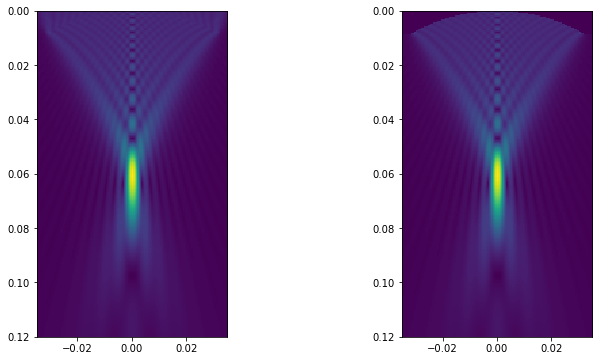

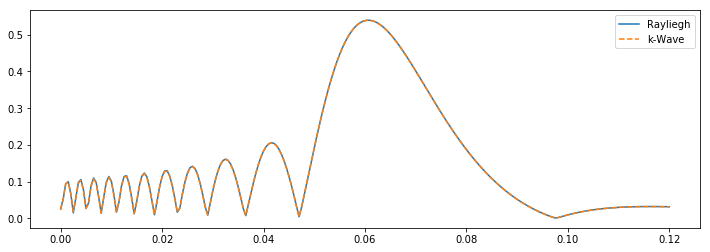

In [8]:
A=loadmat('C:\\Users\\samme\\Documents\\ITRUSST\\DATA\\PH1-BM1-MP2-SC1_FOCUS.mat')
plt.figure(figsize=(12,6))
cy=np.argmin(np.abs(yfield))
plt.subplot(1,2,1)
plt.imshow(np.abs(u2[:,0,:].T),extent=(yfmin,yfmax,zfmax,zfmin))
plt.subplot(1,2,2)
plt.imshow(A['p_amp'],extent=(yfmin,yfmax,zfmax,zfmin))

plt.figure(figsize=(12,4))
plt.plot(zfield,np.abs(u2[cy,0,:])/1e6)
plt.plot(A['x_ax'].flatten(),A['p_amp'][:,int(A['p_amp'].shape[1]/2)]/1e6,'--')
plt.legend(['Rayliegh','k-Wave'])

